## Import modules

In [1]:
from __future__ import division

import os; os.chdir(os.path.join('..', '..', '..'))
print os.getcwd()

/Users/eharkin/Documents/projects/5HTGIF


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import seaborn as sns
import pandas as pd
from scipy import stats

from grr.cell_class import Cell
from grr.Trace import detectSpikes
from grr.Tools import stripNan
from ezephys.pltools import hide_border

In [3]:
plt.style.use(os.path.join('figs', 'scripts', 'writeup', 'publication_figure_style.dms'))
IMG_PATH = os.path.join('figs', 'ims', 'writeup', 'fI')

## Load data

First we'll just load the current step data.

In [4]:
DATA_PATH = os.path.join('data', 'raw', 'GABA', 'current_steps')

fnames = pd.read_csv(os.path.join(DATA_PATH, 'index.csv'))
fnames

,Cell,R,C,hold,Steps
0,DRN350,1700,42.0,-0.6,18711000.abf
1,DRN351,1600,38.0,-7.3,18711018.abf
2,DRN354,831,59.0,-8.5,18711033.abf
3,DRN355,960,36.0,-20.0,18711046.abf
4,DRN356,564,50.5,-5.5,18711060.abf
5,DRN357,552,55.0,-7.3,18711076.abf
6,DRN358,1200,38.0,10.0,18711091.abf
7,DRN421,836,71.0,-11.0,19114005.abf
8,DRN422,1400,57.0,13.4,19114022.abf
9,DRN424,1400,32.0,-9.8,19114045.abf


**Drop JF's cells for now** since only one is usable and would require significant code modification. (2 cells with current channel not registered, one cell with current steps at a different time than my cells.)

In [5]:
fnames.drop(fnames.index[14:17], inplace = True)

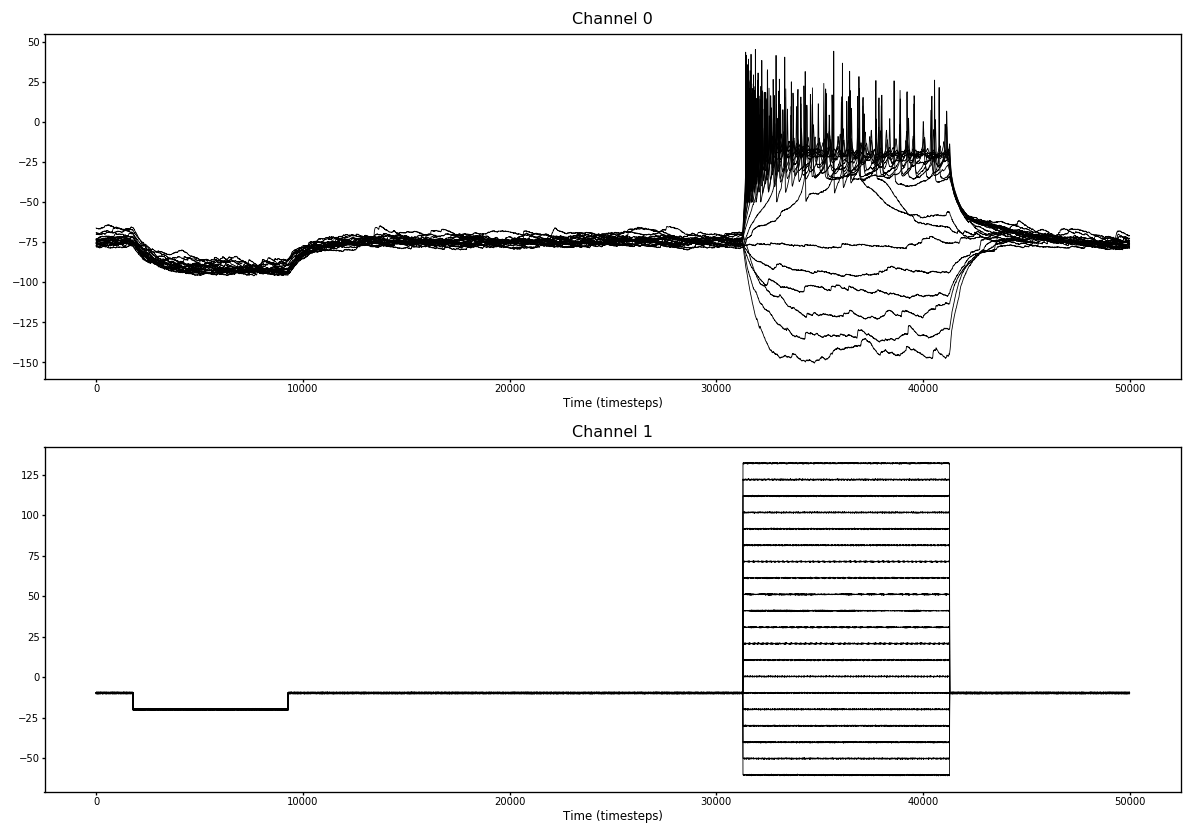

In [6]:
curr_steps = Cell().read_ABF([os.path.join(DATA_PATH, fn) for fn in fnames['Steps']])
curr_steps[0].plot()

Current step recordings have a similar structure, but differ in number of sweeps. Also possibly in spacing of current steps.

Automatically detect the start/end of the test pulse and current steps based on the first recording and then show whether this works for all cells.

In [7]:
change_threshold = 5. # pA threshold at which to detect a step.

tstpts = {}
mainpts = {}

try:
    tstpts['start'], mainpts['start'] = np.where(np.diff(curr_steps[0][1, :, 0]) < -change_threshold)[0]
    tstpts['stop'], mainpts['stop'] = np.where(np.diff(curr_steps[0][1, :, 0]) > change_threshold)[0]
except ValueError:
    print 'Too many or too few steps detected. Might need to adjust `change_threshold`.'
    raise

del change_threshold

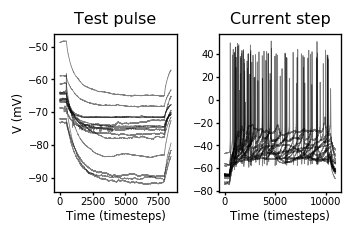

In [8]:
dt = 0.1 # ms. Assumed.

buffer_timesteps = 500

plt.figure()

tst_ax = plt.subplot(121)
tst_ax.set_title('Test pulse')

step_ax = plt.subplot(122)
step_ax.set_title('Current step')

for expt in curr_steps:
    tst_ax.plot(
        expt[0, (tstpts['start'] - buffer_timesteps):(tstpts['stop'] + buffer_timesteps), :].mean(axis = 1), 
        'k-', lw = 0.5, alpha = 0.5
    )
    step_ax.plot(
        expt[0, (mainpts['start'] - buffer_timesteps):(mainpts['stop'] + buffer_timesteps), 8], 
        'k-', lw = 0.5, alpha = 0.5
    )
    
tst_ax.set_xlabel('Time (timesteps)')
tst_ax.set_ylabel('V (mV)')

step_ax.set_xlabel('Time (timesteps)')
step_ax.set_ylabel('')

plt.tight_layout()

plt.show()

Quality control. Remove experiments where $I$ channel wasn't registered correctly. Cells being rejected are plotted, and number of retained cells is printed at the end.

In [9]:
qc_mask = []
for i, rec in enumerate(curr_steps):
    if (np.abs(rec[1, :, :] - np.mean(rec[1, :, :])) < 1.).all() :
        qc_mask.append(False)
        rec.plot()
    else:
        qc_mask.append(True)
        
curr_steps = [curr_steps[i] for i in range(len(curr_steps)) if qc_mask[i]]
print '{} of {} cells passed quality control.'.format(len(curr_steps), len(qc_mask))

del qc_mask

14 of 14 cells passed quality control.


## Generate f/I curves

f/I curves are usually rectified linear. However, in some cases non-monotonic f/I curves are observed, usually due to depolarization block.

In [10]:
# Detect spikes in all recordings.
spktimes = [detectSpikes(rec[0, :, :], 0., 3., 0, 0.1) for rec in curr_steps]

In [11]:
spktimes

[[array([], dtype=float64),
  array([], dtype=float64),
  array([], dtype=float64),
  array([], dtype=float64),
  array([], dtype=float64),
  array([], dtype=float64),
  array([3429.9, 3567.4, 3609.6, 3644.4, 3689.2, 3770.9]),
  array([3288.4, 3330.6, 3362. , 3393.8, 3423.4, 3463.9, 3519.2, 3691.7]),
  array([3211. , 3247.8, 3275.9, 3304.5, 3334.9, 3370.3, 3407.7, 3454.3,
         3528.4, 3646.6, 3859. , 4054.9]),
  array([3188.7, 3219.5, 3246.3, 3274.6, 3301.5, 3329.7, 3361.1, 3407.9,
         3462.6, 3531.4, 3606.8, 3682.5, 3799.6, 3921.6, 4076.8]),
  array([3173.1, 3201.8, 3230.9, 3254.2, 3279.3, 3309.7, 3342.6, 3386.7,
         3437.2, 3492.4, 3559.1, 3637.9, 3708.6, 3785.7, 3887.8, 3956.3,
         4041.6]),
  array([3167.8, 3192.9, 3215. , 3237.9, 3262.3, 3289.8, 3321.1, 3360.2,
         3630. , 3707.5, 3796.8, 3888.7, 3955.4, 4036.7, 4113.4]),
  array([3157.9, 3179.3, 3198.6, 3220. , 3240.9, 3265. , 3294.8, 3545.3,
         3603.6, 3652.5, 3714.3, 3772.4, 3928.9, 4001. , 4058.7]

In [12]:
# Extract f/I data.

# Dict to hold output.
fi_data = {'f': [], 'I': [], 'CV': [], 'rheobase': [], 'freq_at_rheobase': [], 'coeffs': [], 'is_monotonic': []}

# Throwaway function to detect whether an f/I curve increases monotonically.
is_monotonic = lambda x_: np.all(np.nan_to_num(np.diff(x_) / x_[:-1]) > -0.25)

for rec, times in zip(curr_steps, spktimes):
    
    spks_in_window = [x[np.logical_and(x >= mainpts['start'] * dt, x < mainpts['stop'] * dt)] * dt for x in times]
    ISIs_tmp = [np.diff(x) for x in spks_in_window]
    cv_tmp = [x.std() / x.mean() if len(x) > 0 else 0 for x in ISIs_tmp]
    
    f_tmp = np.array(
            [len(x) for x in spks_in_window]
        ) / (1e-3 * dt * (mainpts['stop'] - mainpts['start'])) # Convert to a rate in Hz.
    I_tmp = rec[1, (mainpts['stop'] - 1000):(mainpts['stop'] - 10), :].mean(axis = 0) # Scrape input current.
    
    try:
        rheobase_ind = np.where(f_tmp > 1e-4)[0][0]
        freq_at_rheobase_tmp = f_tmp[rheobase_ind]
    except IndexError:
        rec.plot()
        print f_tmp
        print times
        raise
    
    if is_monotonic(f_tmp):
        coeffs_tmp = np.polyfit(I_tmp[rheobase_ind:], f_tmp[rheobase_ind:], 1)
    else:
        coeffs_tmp = [np.nan for i in range(2)]
        
    fi_data['f'].append(f_tmp)
    fi_data['I'].append(I_tmp)
    fi_data['CV'].append(cv_tmp)
    fi_data['rheobase'].append(I_tmp[rheobase_ind])
    fi_data['freq_at_rheobase'].append(freq_at_rheobase_tmp)
    fi_data['coeffs'].append(coeffs_tmp)
    fi_data['is_monotonic'].append(is_monotonic(f_tmp))
    
fi_data['coeffs'] = np.array(fi_data['coeffs'])

/miniconda3/envs/neopozz/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/miniconda3/envs/neopozz/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


In [13]:
fi_df = pd.DataFrame({
    'rheobase': fi_data['rheobase'], 
    'freq_at_rheobase': fi_data['freq_at_rheobase'],
    'gain': fi_data['coeffs'][:, 0], 
    'is_monotonic': fi_data['is_monotonic']
})
fi_df.to_csv(os.path.join('data', 'processed', 'GABA', 'current_steps_gain.csv'), index=False)

/miniconda3/envs/neopozz/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/miniconda3/envs/neopozz/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


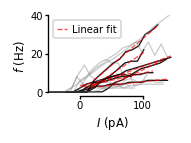

In [14]:
plt.figure(figsize=(1.5, 1))

curves = plt.subplot(111)

legend_flag = False
for x, y, coeffs in zip(fi_data['I'], fi_data['f'], fi_data['coeffs']):
    
    if is_monotonic(y):
        curves.plot(x, y, 'k-', alpha = 0.9)
        
        if not legend_flag:
            curves.plot(
                x[y>1e-3],
                np.polyval(coeffs, x[y>1e-3]),
                'r--',
                alpha = 0.7,
                label = 'Linear fit'
            )
            legend_flag = True
        else:
            curves.plot(x[y>1e-3], np.polyval(coeffs, x[y>1e-3]), 
                             'r--', alpha = 0.7)
    else:
        curves.plot(x, y, '-', color = 'gray', alpha = 0.4)

curves.set_xlim(-50, 155)
curves.set_ylim(-2, 40)

curves.legend(loc='upper left')
curves.set_xlabel('$I$ (pA)')
curves.set_ylabel('$f$ (Hz)')
hide_border('tr', ax=curves, trim=True)

plt.subplots_adjust(top=0.97, right=0.97, bottom=0.3, left=0.25)

if IMG_PATH is not None:
    plt.savefig(os.path.join(IMG_PATH, 'som_fi_curve_only.png'))
    plt.savefig(os.path.join(IMG_PATH, 'som_fi_curve_only.svg'))

/miniconda3/envs/neopozz/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/miniconda3/envs/neopozz/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


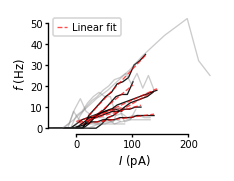

In [18]:
plt.figure(figsize=(2, 1.5))

curves = plt.subplot(111)

legend_flag = False
for x, y, coeffs in zip(fi_data['I'], fi_data['f'], fi_data['coeffs']):
    
    if is_monotonic(y):
        curves.plot(x, y, 'k-', alpha = 0.9)
        
        if not legend_flag:
            curves.plot(
                x[y>1e-3],
                np.polyval(coeffs, x[y>1e-3]),
                'r--',
                alpha = 0.7,
                label = 'Linear fit'
            )
            legend_flag = True
        else:
            curves.plot(x[y>1e-3], np.polyval(coeffs, x[y>1e-3]), 
                             'r--', alpha = 0.7)
    else:
        curves.plot(x, y, '-', color = 'gray', alpha = 0.4)

curves.set_xlim(-50, curves.get_xlim()[1])

curves.legend(loc='upper left')
curves.set_xlabel('$I$ (pA)')
curves.set_ylabel('$f$ (Hz)')
hide_border('tr', ax=curves, trim=True)

plt.subplots_adjust(top=0.97, right=0.97, bottom=0.3, left=0.25)

if IMG_PATH is not None:
    plt.savefig(os.path.join(IMG_PATH, 'som_fi_curve_only_unscaled.png'))
    plt.savefig(os.path.join(IMG_PATH, 'som_fi_curve_only_unscaled.svg'))

In [16]:
print(
    'Rheobase: {:.3f} +/- {:.3f} pA'.format(
        np.nanmean(fi_data['rheobase']), stats.sem(fi_data['rheobase'], nan_policy='omit')
    )
)
print(
    'Gain: {:.3f} +/- {:.3f} Hz/pA'.format(
        np.nanmean(fi_data['coeffs'][:, 0]), stats.sem(fi_data['coeffs'][:, 0], nan_policy='omit')
    )
)

Rheobase: 11.319 +/- 4.273 pA
Gain: 0.139 +/- 0.033 Hz/pA


Half of the cells have linear monotonic curves. Current steps of cells from the non-monotonic group are below.

/miniconda3/envs/neopozz/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/miniconda3/envs/neopozz/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


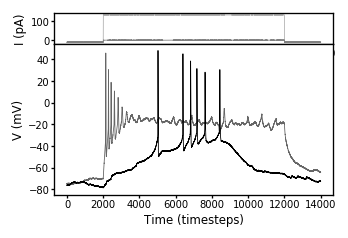

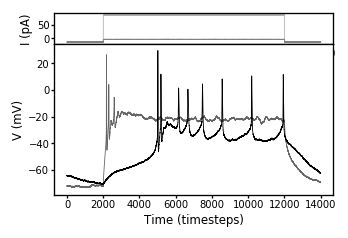

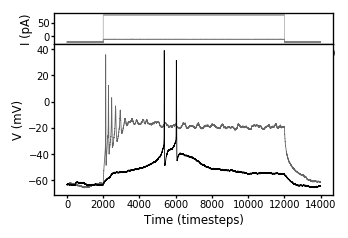

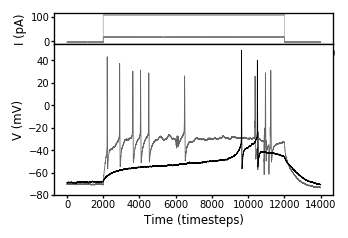

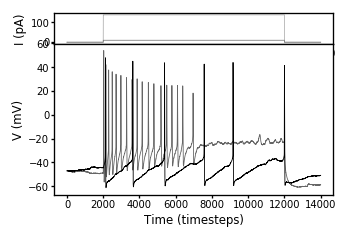

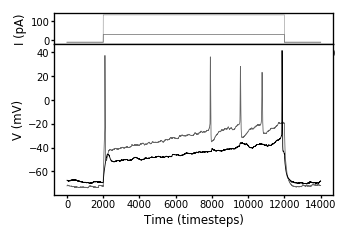

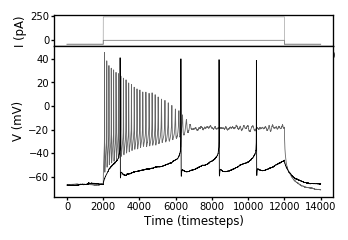

In [17]:
for y, rec in zip(fi_data['f'], curr_steps):
    if not is_monotonic(y):
        first_sweep_with_spikes = np.min(np.where(y > 0)[0])
        
        plt.figure()
        spec_tmp = gs.GridSpec(2, 1, height_ratios = [0.2, 1], hspace = 0)
        
        plt.subplot(spec_tmp[0, :])
        plt.plot(
            rec[1, (mainpts['start'] - 2000):(mainpts['stop'] + 2000), first_sweep_with_spikes],
            '-', color = 'gray', lw = 0.5
        )
        plt.plot(
            rec[1, (mainpts['start'] - 2000):(mainpts['stop'] + 2000), -1],
            '-', color = 'gray', lw = 0.5, alpha = 0.6
        )
        
        plt.ylabel('I (pA)')
        
        plt.subplot(spec_tmp[1, :])
        plt.plot(
            rec[0, (mainpts['start'] - 2000):(mainpts['stop'] + 2000), first_sweep_with_spikes],
            'k-', lw = 0.5
        )
        plt.plot(
            rec[0, (mainpts['start'] - 2000):(mainpts['stop'] + 2000), -1],
            'k-', lw = 0.5, alpha = 0.6
        )
        
        plt.ylabel('V (mV)')
        plt.xlabel('Time (timesteps)')
        
        plt.show()

Usually the cells have non-monotonic f/I curves because they go into depolarization block. In one case, it looks to be due to a weird 'either delayed or immediate' firing phenotype. The last cell went into depol. block because I pushed it harder than the others, which isn't very interesting.